# Development of CRC region filter

In [1]:
import numpy as np
import pandas as pd
from typing import List
import seaborn as sns
from matplotlib import pyplot as plt
import os

import featureio 
import calzone

from pineapple.contrib.components.data_factories.matrix_factory import MatrixFactory as mf
from pineapple.contrib.components.transformers.methyl.poisson_outlier import ChooseSettingsAndRegionsForPoissonV2

from pineapple.contrib.results.results_loader import load_results
from pineappleflow.core.loaders.contrib.experiment_loader import ExperimentLoader
import pineappleflow.core.experiment_context as experiment_context
import datetime
experiment_context.reset_context(0, "x", "x", datetime.datetime(2021, 3, 30,0,0))

from collections import defaultdict, Counter
print("a")

a


In [10]:
# samples for measuring region specificity (training only)
multicancer_tissue=[
        'pancreatic_cancer_tissue_ds_FF_v1',
        'ovarian_cancer_tissue_ds_FF_v1',
        'lung_cancer_methyl_DMR_tissue_ds_FF_merged',
        'liver_cancer_tissue_ds_FF_v1',
        'prostate_cancer_tissue_ds_FF_v1',
        'breast_cancer_tissue_ds_FF_v1',
        'kidney_cancer_tissue_ds_FF_v1',
        'nonhodgkinslymphoma_cancer_tissue_ds_FF_v1',
        'stomach_cancer_tissue_ds_FF_v1',
        'uterine_cancer_tissue_ds_FF_v1',
        'colorectal_tissue_cancer_stage_I_chemo_n',
        'colorectal_tissue_cancer_stage_I_chemo_y',
        'colorectal_tissue_cancer_stage_II_chemo_n',
        'colorectal_tissue_cancer_stage_II_chemo_y',
        'colorectal_tissue_cancer_stage_III_chemo_n',
        'colorectal_tissue_cancer_stage_III_chemo_y',
        'colorectal_tissue_cancer_stage_IV_chemo_y',
        'colorectal_tissue_cancer_stage_IV_chemo_y',
    ]
multicancer_negs=['Neg_noM4_centipedeC_cpg_dense_v3',
                  'M4_negs_cpg_dense_no96plasmas_v1']
# not summarized
# cpg_dense_neg=['colorectal_plasma_healthy_nodiscovery_polyp_y',
#                'colorectal_plasma_healthy_nodiscovery_polyp_n']

# samples for testing models

panel_of_neg=['colorectal_healthy_temseqV4_v1v2_discovery2alpha_v7_panelofneg',
              'colorectal_healthy_temseqV4_v1v2_discovery2beta_v4_panelofneg',
              'colorectal_healthy_temseqV4_v1v2_discovery2delta_v4_panelofneg',
              'colorectal_healthy_temseqV4_v1v2_discovery2gamma_v3_panelofneg']
# m4=['colorectal_healthy_temseqV4_m4_phase1_v1',
#     'colorectal_healthy_temseqV4_m4_phase2_v1']
m3=['colorectal_benign_temseqV4_english_m3_v1',
    'colorectal_cancer_temseqV4_english_m3_v1',
    'colorectal_healthy_temseqV4_english_m3_v1',
    'colorectal_precancer_temseqV4_english_m3_v1']

tclasses = panel_of_neg + m3 
all_dsids = []
for training_class in tclasses:
    dsids = featureio.FeatureIO().get_datasets_for_training_class(training_class)
    all_dsids.append(dsids)
all_dsids = [dsid for subls in all_dsids for dsid in subls]
metas = calzone.Calzone.get_dataset_metadata_with_ids(all_dsids)
#print(metas[0])
cancer_types = [m.raw_sample_metadata['lims_top_diagnosis']['cancer_type'] for m in metas]
Counter(cancer_types)

Missed Redis cache for ttl_key TS-212521487, reading from BigQuery instead


Counter({'Colorectal Normal / Healthy': 236,
         'Colorectal Benign': 28,
         'Colorectal Pre-Cancer': 125,
         'Colorectal Cancer': 125})

In [2]:
# make col metadata for new feature mint-chmcfc-VP2-V4-overlap-regions
dim_regions = []
dim_thresholds = np.array([{'cpgs':i} for i in range(3,34)])
dim_counts = np.array([{"mcpgs":'mcpgs'},{"tcpgs":'tcpgs'}])
with open("./VP2_V4_overlap.bed","r") as fin:
    for line in fin:
        chrm, start, stop = line.split("\t")
        dim_regions.append({"chrm":chrm,"start":start,"stop":stop.strip()})

# update feature column metadata (which can't be done by MINT) 330 regions
with featureio.FeatureIO() as ftio:
    ftio.update_column_metadata(feature='mint-chmcfc-VP2-V4-overlap-regions',
                                version=3,
                                column_metadata = (dim_regions, dim_thresholds, dim_counts))

In [3]:
# get column metadata from bed file
with open("./VP2_V4_overlap.bed","r") as fin:
    chrms=[]
    starts=[]
    ends=[]
    dicts = []
    for line in fin.readlines():
        chrm, start, end = line.split("\t")
        chrms.append(chrm)
        starts.append(start)
        ends.append(end.strip())
        dicts.append({"chrm":chrm,"start":start,"end":end.strip()})
print(chrms[0:3])
print(starts[0:3])
print(ends[0:3])
regions = [f"{chrm}:{start}-{end}" for chrm,start,end in zip(chrms,starts,ends)]

['chr1', 'chr1', 'chr1']
['3747121', '9651384', '11691842']
['3747628', '9653124', '11692387']


In [4]:
# rerun these models to get the cpg thresholds from CV runs using the new feature

bucket = "freenome-user-data-bgould"
lung_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Lung_tissue_CHMFC_VP2_V4_overlap"
liver_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Liver_tissue_CHMFC_VP2_V4_overlap"
prostate_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Prostate_tissue_CHMFC_VP2_V4_overlap"
ovarian_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/ovarian_tissue_CHMFC_VP2_V4_overlap"
uterine_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Uterine_tissue_CHMFC_VP2_V4_overlap"
pancreatic_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Pancreatic_tissue_CHMFC_VP2_V4_overlap"
breast_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Breast_tissue_CHMFC_VP2_V4_overlap"
stomach_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Stomach_tissue_CHMFC_VP2_V4_overlap"
crc_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/CRC_tissue_CHMFC_VP2_V4_overlap"
lymphoma_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Lymphoma_tissue_CHMFC_VP2_V4_overlap"
kidney_path = "Multi_cancer/cpg_threshold_models_VP2_V4_overlap_regions/Kidney_tissue_CHMFC_VP2_V4_overlap"


paths = [lung_path,liver_path, prostate_path,
         ovarian_path,uterine_path,pancreatic_path,
         breast_path,stomach_path,lymphoma_path,
         kidney_path,crc_path
        ]
cancer_types = ["Lung_Cancer","Liver_Cancer","Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Stomach_Cancer","Lymphoma",
                "Kidney_Cancer","CRC"
               ]

stage_dict = {"I":"I","II":"II","III":"III","IV":"IV",
             "IA":"I","IB":"I","IC":"I",
             "IIA":"II","IIB":"II","IIC":"II",
             "IIIA":"III","IIIB":"III","IIIC":"III",
             "IV":"IV","IVA":"IV","IVB":"IV","IVC":"IV",
             None:"Unknown", "Unavailable":"Unknown"}
stages = ["I","II","III","IV","Unknown"]

In [ ]:
#get all VP2 regions and effect sizes, write to file

# bucket = "freenome-user-data-bgould"
# dict_effect_sizes = {}
# for cancer_type, path in zip(cancer_types, paths):
#     loader = ExperimentLoader(bucket, path)
#     folds = loader.fold_names()
#     effect_sizes = []

#     for fold_name in folds:
#         fold = loader.fold(fold_name)
#         choose_reg =fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v4'][1]
#         #poisson = fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-multicancer-dsc/v1'][2]
#         col_meta = fold.pre_transformer_fold_holder.test['mint-chmcfc-multicancer-dsc/v4'].column_metadata
#         effect_sizes.append(choose_reg.pessimistic_effect_size)
#         assert len(choose_reg.pessimistic_effect_size)==len(col_meta)
    
#     #genes = [d["name"] for d in col_meta]
#     #coords = [f'{d["seqname"]}:{d["start"]}-{d["end"]}' for d in col_meta]
#     med_effect_sizes = pd.DataFrame(effect_sizes).median(axis=0)
#     dict_effect_sizes[cancer_type] = med_effect_sizes
#     print(f'{cancer_type} complete.')
    
# df_effect_sizes = pd.DataFrame.from_dict(dict_effect_sizes)


### try measuring region specificity with HMF rate instead of effect size

In [5]:
cancer_type_to_train_sets = {"Lung_Cancer":["lung_cancer_methyl_DMR_tissue_ds_FF_merged"],
                             "Liver_Cancer":["liver_cancer_tissue_ds_FF_v1"],
                             "Prostate_Cancer":["prostate_cancer_tissue_ds_FF_v1"],
                             "Ovarian_Cancer":["ovarian_cancer_tissue_ds_FF_v1"],
                             "Uterine_Cancer":["uterine_cancer_tissue_ds_FF_v1"],
                             "Pancreatic_Cancer":["pancreatic_cancer_tissue_ds_FF_v1"],
                             "Breast_Cancer":["breast_cancer_tissue_ds_FF_v1"],
                             "Stomach_Cancer":["stomach_cancer_tissue_ds_FF_v1"],
                             "Kidney_Cancer":["kidney_cancer_tissue_ds_FF_v1"],
                             "Lymphoma":["nonhodgkinslymphoma_cancer_tissue_ds_FF_v1"],
                             "CRC":["colorectal_tissue_cancer_stage_IV_chemo_n",
                                            "colorectal_tissue_cancer_stage_IV_chemo_y",
                                            "colorectal_tissue_cancer_stage_III_chemo_n",
                                            "colorectal_tissue_cancer_stage_III_chemo_y",
                                            "colorectal_tissue_cancer_stage_II_chemo_n",
                                            "colorectal_tissue_cancer_stage_II_chemo_y",
                                            "colorectal_tissue_cancer_stage_I_chemo_n",
                                            "colorectal_tissue_cancer_stage_I_chemo_y"]
                            }

In [6]:
# extract hmf data at model cpg thresholds
# get avg. CpG thresholds learned by each model and subset test data

cutoffs_list = []
data_dfs = []
for i,(path,cancer_type) in enumerate(zip(paths,cancer_types)):
    loader = ExperimentLoader(bucket, path)
    folds = loader.fold_names()
    cpg_cutoffs =[]
    for fold_name in folds:
        fold = loader.fold(fold_name)
        choose_reg =fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-VP2-V4-overlap-regions/v3'][0]
        cpg_cutoffs.append(choose_reg.best_feature_per_region)
    cpg_cutoffs = pd.DataFrame(cpg_cutoffs).mean(axis=0)
    cutoffs_list.append(cpg_cutoffs)
    
    # filter data to type-specific cpg cutoffs
    print(cancer_type_to_train_sets[cancer_type])
    mat = mf.create_from_training_classes(training_classes=cancer_type_to_train_sets[cancer_type],
                                          feature_str='mint-chmcfc-VP2-V4-overlap-regions/v3',
                                          class_labels=np.repeat(1, len(cancer_type_to_train_sets[cancer_type]))
                                         )
    hmf_rates = mat.x[...,0]/mat.x[...,1]
    data = []
    for i , cutoff in enumerate(cpg_cutoffs):
        data.append(hmf_rates[:,i,int(np.round(cutoff,0))])
    df_data = pd.DataFrame(data, columns=mat.sample_ids, index=regions).T ##sids x regions
    #df_data = df_data.fillna(0)
    data_dfs.append(df_data)

['lung_cancer_methyl_DMR_tissue_ds_FF_merged']
['liver_cancer_tissue_ds_FF_v1']
['prostate_cancer_tissue_ds_FF_v1']
['ovarian_cancer_tissue_ds_FF_v1']
['uterine_cancer_tissue_ds_FF_v1']
['pancreatic_cancer_tissue_ds_FF_v1']
['breast_cancer_tissue_ds_FF_v1']
['stomach_cancer_tissue_ds_FF_v1']
['nonhodgkinslymphoma_cancer_tissue_ds_FF_v1']
['kidney_cancer_tissue_ds_FF_v1']
['colorectal_tissue_cancer_stage_IV_chemo_n', 'colorectal_tissue_cancer_stage_IV_chemo_y', 'colorectal_tissue_cancer_stage_III_chemo_n', 'colorectal_tissue_cancer_stage_III_chemo_y', 'colorectal_tissue_cancer_stage_II_chemo_n', 'colorectal_tissue_cancer_stage_II_chemo_y', 'colorectal_tissue_cancer_stage_I_chemo_n', 'colorectal_tissue_cancer_stage_I_chemo_y']


                        Lung_Cancer  Liver_Cancer  Prostate_Cancer  \
chr1:3747121-3747628       0.042850      0.042850         0.042850   
chr1:9651384-9653124       0.092068      0.092316         0.092316   
chr1:11691842-11692387     0.000000      0.000000         0.000000   
chr1:18636153-18637488     0.021250      0.021250         0.021250   
chr1:34928854-34930628     0.137021      0.137021         0.137021   

                        Ovarian_Cancer  Uterine_Cancer  Pancreatic_Cancer  \
chr1:3747121-3747628          0.042850        0.042850           0.042850   
chr1:9651384-9653124          0.092316        0.090982           0.092316   
chr1:11691842-11692387        0.000000        0.000000           0.000000   
chr1:18636153-18637488        0.021250        0.021250           0.021250   
chr1:34928854-34930628        0.137021        0.137021           0.136169   

                        Breast_Cancer  Stomach_Cancer  Lymphoma  \
chr1:3747121-3747628         0.042850        0.04

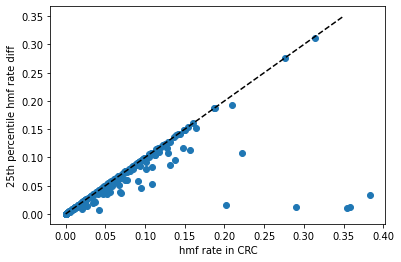

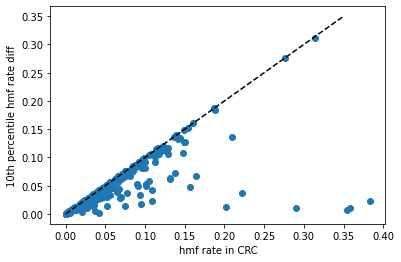

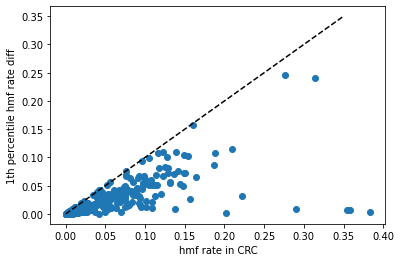

In [10]:
crc_median_hmf_rates = data_dfs[-1].median(axis=0, skipna=True)

metric_dict = {}
for cancer_type, df in zip(cancer_types[0:-1], data_dfs[0:-1]):
    median_hmf_rates = df.median(axis=0, skipna=True) #throws nans if all values are nan
    diffs = np.abs(crc_median_hmf_rates - median_hmf_rates)
    #diffs = diffs.fillna(0)
    metric_dict[cancer_type] = diffs

df_metrics = pd.DataFrame.from_dict(metric_dict) # regions x cancer_types

# df_metrics["med_hmf_rate_diff"] = df_metrics.median(axis=1, skipna=True)
# print(max(df_metrics["med_hmf_rate_diff"]))
# print(min(df_metrics["med_hmf_rate_diff"]))

df_metrics["25th_pctl_hmf_rate_diff"] = df_metrics.apply(lambda col: np.percentile(col,25), axis=1)
df_metrics["10th_pctl_hmf_rate_diff"] = df_metrics.apply(lambda col: np.percentile(col,10), axis=1)
df_metrics["1th_pctl_hmf_rate_diff"] = df_metrics.apply(lambda col: np.percentile(col,1), axis=1)
df_metrics["regions"] = regions
print(df_metrics.head())
plt.figure()
plt.scatter(crc_median_hmf_rates, df_metrics["25th_pctl_hmf_rate_diff"])
plt.ylabel("25th percentile hmf rate diff")
plt.xlabel("hmf rate in CRC")
plt.plot([0,0.35],[0,0.35],"--k")

plt.figure()
plt.scatter(crc_median_hmf_rates, df_metrics["10th_pctl_hmf_rate_diff"])
plt.ylabel("10th percentile hmf rate diff")
plt.xlabel("hmf rate in CRC")
plt.plot([0,0.35],[0,0.35],"--k")

plt.figure()
plt.scatter(crc_median_hmf_rates, df_metrics["1th_pctl_hmf_rate_diff"])
plt.ylabel("1th percentile hmf rate diff")
plt.xlabel("hmf rate in CRC")
plt.plot([0,0.35],[0,0.35],"--k")

# only write metric for regions with non nan value
# print(df_metrics.shape)
keep_reg = ~df_metrics["25th_pctl_hmf_rate_diff"].isna()
df_metrics = df_metrics[keep_reg]
print(df_metrics.shape)
with open("./VP2_V4_overlap_chmfc_reg_rate_diffs.csv","w") as fout:
    df_metrics.to_csv(fout, index=False)

<AxesSubplot:xlabel='1th_pctl_hmf_rate_diff', ylabel='Density'>

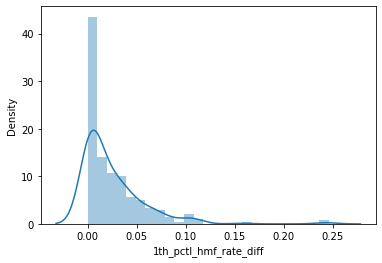

In [11]:
plt.figure()
sns.distplot(df_metrics["1th_pctl_hmf_rate_diff"])

In [ ]:
# p = range(len(df_metrics))
# plt.figure()
# plt.plot(sorted(df_metrics["med_hmf_rate_diff"]),p)
# plt.ylabel("cumulative number of regions")
# plt.xlabel("median_hmf_rate_diff")

In [203]:
# what is overlap between VP2 and V4 panel?
vp2_bed = pd.read_csv("./VP2_panel.bed", sep="\t", header=None)
v4_overlap_bed = pd.read_csv("./VP2_V4_overlap.bed", sep="\t", header=None)

total_vp2_bp = sum(vp2_bed.iloc[:,2] - vp2_bed.iloc[:,1])
total_overlap = sum(v4_overlap_bed.iloc[:,6])

print(total_overlap/float(total_vp2_bp))




0.5573844821735722


In [ ]:
## run model with filtering transformer. extract fold sensitivity

In [ ]:
# bucket = 'freenome-user-data-bgould'
# path = 'Multi_cancer/CRC_spec_filtering/Region_filtering_HPO'

# # check the weight vector looks ok . . .
# loader = ExperimentLoader(bucket, path)
# folds = loader.fold_names()
# for fold_name in folds:
#     fold = loader.fold(fold_name)
#     filter_tfmr = fold._pipeline_result.pipeline.transformer_chains['mint-chmcfc-VP2-V4-overlap-regions/v3'][2]
#     print(filter_tfmr.wv)
    

# search_loader = loader.search_loader
# search_loader.hyperparam_search_dict
# search_loader.search_fold_names

In [12]:
# for each inner fold get the top_pct_reg_to_retain and the number of reg retained.
bucket = 'freenome-user-data-bgould'
# path = 'Multi_cancer/CRC_spec_filtering/Region_filtering_HPO'
path = 'Multi_cancer/CRC_spec_filtering/Region_filtering_HPO_1pctl'

loader = ExperimentLoader(bucket, path)
search_loader = loader.search_loader
folds = search_loader.search_fold_names
specs = search_loader.spec_names
plot_dfs = []
for spec_name in specs:
#     if os.path.exists(f"./HPO_reg_retained_by_thresh_{spec_name}.csv"):
#         continue
    if os.path.exists(f"./HPO_1pctl_reg_retained_by_thresh_{spec_name}.csv"):  
        continue
    folds = search_loader.spec(spec_name).fold_names()
    regs_filter = []
    #regs_poisson = []
    params = []
    for fold in folds:
        filter_tfmr = search_loader.spec(spec_name).fold(fold).feature('mint-chmcfc-VP2-V4-overlap-regions/v3').fitted_transformers[2]
        #poisson_tfmr = search_loader.spec(spec_name).fold(fold).feature('mint-chmcfc-VP2-V4-overlap-regions/v3').fitted_transformers[3]
        n_reg_filter = sum([w!=0 for w in filter_tfmr.wv])
        #n_reg_poisson = sum(poisson_tfmr.features_to_keep)
        param = filter_tfmr.top_pct_reg_to_retain
        regs_filter.append(n_reg_filter)
        #regs_poisson.append(n_reg_poisson)
        params.append(param)
    df = pd.DataFrame({'n_reg_filter':regs_filter,'param':params})
    print(spec_name)
    plot_dfs.append(df)
    print(df.head())
#     df.to_csv(open(f"./HPO_reg_retained_by_thresh_{spec_name}.csv","w"),index=None)
    df.to_csv(open(f"./HPO_1pctl_reg_retained_by_thresh_{spec_name}.csv","w"),index=None) #125 fold values per file

spec_0
   n_reg_filter param
0           200  None
1           198  None
2           195  None
3           196  None
4           199  None
spec_1
   n_reg_filter  param
0           243  100.0
1           243  100.0
2           240  100.0
3           240  100.0
4           245  100.0
spec_2
   n_reg_filter  param
0           219   90.0
1           219   90.0
2           217   90.0
3           217   90.0
4           221   90.0
spec_3
   n_reg_filter  param
0           195   80.0
1           195   80.0
2           193   80.0
3           193   80.0
4           197   80.0
spec_4
   n_reg_filter  param
0           171   70.0
1           171   70.0
2           169   70.0
3           169   70.0
4           172   70.0
spec_5
   n_reg_filter  param
0           146   60.0
1           146   60.0
2           145   60.0
3           145   60.0
4           148   60.0
spec_6
   n_reg_filter  param
0           122   50.0
1           122   50.0
2           121   50.0
3           121   50.0
4           12

In [13]:
df_all = pd.concat(plot_dfs)
# df_all.to_csv(open("./HPO_reg_retained_by_thresh.csv","w"),index=None)
df_all.to_csv(open("./HPO_1pctl_reg_retained_by_thresh.csv","w"),index=None)

Text(0.5, 0, 'top pct of regions to retain')

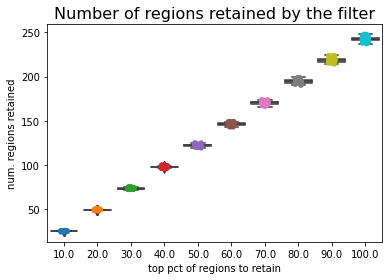

In [14]:
plt.figure()
sns.boxplot(x="param", y="n_reg_filter", data=df_all)
sns.stripplot(x="param", y="n_reg_filter", data=df_all)
plt.title("Number of regions retained by the filter", size=16)
plt.ylabel("num. regions retained")
plt.xlabel("top pct of regions to retain")

# plt.figure()
# sns.boxplot(x="param", y="n_reg_poisson", data=df_all)
# sns.stripplot(x="param", y="n_reg_poisson", data=df_all)
# plt.title("Number of regions retained by the model", size=16)
# plt.ylabel("num. regions retained")
# plt.xlabel("top pct of regions to retain")

In [15]:
from pineapple.contrib.loaders.experiment_table_loader import ExperimentTableLoader


In [16]:
table_loader = ExperimentTableLoader(bucket=bucket,path=path)

df_hyperparam = table_loader.hyperparam_table(metric_names=["test_auc", "test_sens_upperthresh_spec90"])
df_hyperparam.head()

,spec_name,param_name,param_value,metric_name,metric_value
0,spec_0,top_pct_reg_to_retain,NaN,test_auc,0.689757
1,spec_0,top_pct_reg_to_retain,NaN,test_sens_upperthresh_spec90,0.338235
2,spec_1,top_pct_reg_to_retain,100.0,test_auc,0.692616
3,spec_1,top_pct_reg_to_retain,100.0,test_sens_upperthresh_spec90,0.353725
4,spec_2,top_pct_reg_to_retain,90.0,test_auc,0.696977


In [17]:
# df_hyperparam.to_csv(open("./HPO_hyperparam_table.csv","w"),index=None)
df_hyperparam.to_csv(open("./HPO_1pctl_hyperparam_table.csv","w"),index=None)

In [20]:
df_hyperparam = pd.read_csv(open("./HPO_hyperparam_table.csv","r"),header=0)
df_hyperparam.head()

,spec_name,param_name,param_value,metric_name,metric_value
0,spec_0,top_pct_reg_to_retain,NaN,test_auc,0.686966
1,spec_0,top_pct_reg_to_retain,NaN,test_sens_upperthresh_spec90,0.333922
2,spec_1,top_pct_reg_to_retain,100.0,test_auc,0.692616
3,spec_1,top_pct_reg_to_retain,100.0,test_sens_upperthresh_spec90,0.353725
4,spec_2,top_pct_reg_to_retain,90.0,test_auc,0.696076


(0.5, 0.8)

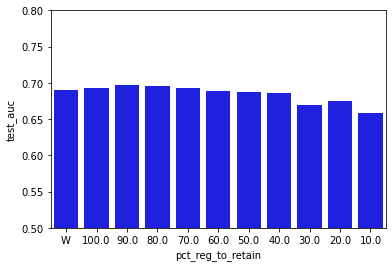

In [19]:

df_hyperparam = df_hyperparam.fillna("W")
df_hyperparam["param"] = df_hyperparam["param_value"].astype(str)
df_aucs = df_hyperparam[df_hyperparam["metric_name"]=="test_auc"]
plt.figure()
sns.barplot(x="param_value", y="metric_value", data=df_aucs, color="blue")
plt.ylabel("test_auc")
plt.xlabel("pct_reg_to_retain")
plt.ylim([0.5,0.8])

Text(0.5, 0, 'pct_reg_to_retain')

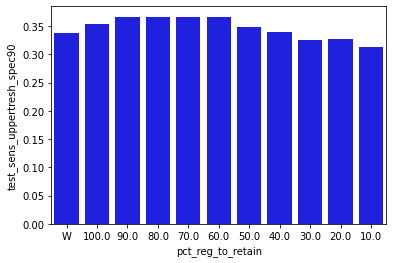

In [20]:
# find parameter chosen in train set final
# find final performance of the model.
# plot sens at 90 spec
df_sens = df_hyperparam[df_hyperparam["metric_name"]=="test_sens_upperthresh_spec90"]
plt.figure()
sns.barplot(x="param_value", y="metric_value", data=df_sens, color="blue")
plt.ylabel("test_sens_uppertresh_spec90")
plt.xlabel("pct_reg_to_retain")
#plt.ylim([0.5,1.0])

In [21]:
from pineapple.contrib.loaders.experiment_loader import InferenceLoader

EXPERIMENT LOADER: Redirecting to use Loaders in Pineappleflow. Please import loaders from 'from pineappleflow.core.loaders.contrib.experiment_loader' instead.


In [24]:
# train several models with different pct_to_retain values. Run inference of those models on a set of 
# multi cancer samples.
cancer_types = ["Healthy",
                "Lung_Cancer","Liver_Cancer",
                "Prostate_Cancer",
                "Ovarian_Cancer","Uterine_Cancer","Pancreatic_Cancer",
                "Breast_Cancer","Esophageal_Cancer","CRC_stageIV"]
                
cancer_to_label = {'Healthy':['Colorectal Normal / Healthy','Colorectal Benign'], 
                   'CRC_stageIV':['Colorectal Cancer','Colorectal Pre-Cancer'],
                   'Pancreatic_Cancer':['Pancreatic Cancer'], #'Pancreatic Pre-Cancer'],
                   'Lung_Cancer':['Lung Cancer'],
                   'Prostate_Cancer':['Prostate Cancer'], 
                   'Esophageal_Cancer':['Esophageal Cancer'], 
                   'Uterine_Cancer':['Uterine Cancer'], 
                   'Ovarian_Cancer':['Ovarian Cancer'], 
                   'Breast_Cancer':['Breast Cancer'], 
                   'Liver_Cancer':['Liver Cancer']
                  }

# pct_thresholds = list(range(10,110,10)) + ["W"]
pct_thresholds = [10,50,100,"W"]

pct_thresholds= [str(p) for p in pct_thresholds]
sens_at_90 = []
aucs = []
tot_FPRs = []
ct_scores = defaultdict(list)
ct_FPRs = defaultdict(list)
for pct in pct_thresholds:
    print(pct)
#     model_path = f"Multi_cancer/CRC_spec_filtering/inference_models/Region_filtering_{pct}"
#     path = f"Multi_cancer/CRC_spec_filtering/inference_models/Region_filtering_{pct}_infer/{model_path}/fold_score_averaging"
    model_path = f"Multi_cancer/CRC_spec_filtering/inference_models/Region_filtering_{pct}_1pctl"
    path = f"Multi_cancer/CRC_spec_filtering/inference_models/Region_filtering_{pct}_1pctl_infer/{model_path}/fold_score_averaging"

    inf_loader = InferenceLoader(bucket,path)
    #print(inf_loader.aggregated_model_metric)
    sens_at_90.append((inf_loader.aggregated_model_metric["sens_upperthresh_spec90"],
                      inf_loader.aggregated_model_metric["sens_upperthresh_spec90_lowerci"],
                      inf_loader.aggregated_model_metric["sens_upperthresh_spec90_upperci"]))
    aucs.append((inf_loader.aggregated_model_metric['auc'],
                inf_loader.aggregated_model_metric['auc_ci_lower95'],
                inf_loader.aggregated_model_metric['auc_ci_upper95']))
    #tot_FPRs.append(inf_loader.aggregated_model_metric['FPR']) #incorrect in pineapple
    
    table_loader = ExperimentTableLoader(bucket=bucket,path=path)
    df_samples = table_loader.sample_score_per_fold_table()
    
    # get 90pct spec score threshold
    labels = cancer_to_label["Healthy"]
    df_healthy = df_samples[[s in labels for s in df_samples["status"].values]]
    cutoff_90 = np.percentile(df_healthy["y_score"].values, 90)     
    
    df_negs = df_samples[df_samples["y_true"]==0]
    # FPR = FPs/(FPs + TN)
    FPR = sum(df_negs["y_score"].values > cutoff_90)/float(len(df_negs))
    tot_FPRs.append(FPR)
    
    for cancer_type in cancer_types:
        labels = cancer_to_label[cancer_type]
        df_cancer = df_samples[[s in labels for s in df_samples["status"].values]]
        ct_scores[pct].append(df_cancer["y_score"])
        FPR = sum([s>cutoff_90 for s in df_cancer["y_score"].values])/float(len(df_cancer))
        ct_FPRs[pct].append(FPR)

10
50
100
W


Text(0.5, 0, 'pct_reg_to_retain')

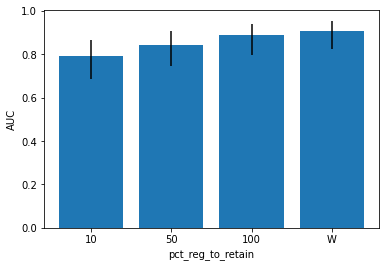

In [25]:
#plot threshold vs AUC

errbars = np.array(pd.DataFrame({'lower':[(a[0]-a[1]) for a in aucs],'upper':[(a[2]-a[0]) for a in aucs]}).T)
#print(errbars)
fig = plt.subplot()
plt.bar(x=pct_thresholds, height=[a[0] for a in aucs])
plt.errorbar(x=pct_thresholds, y=[a[0] for a in aucs], yerr=errbars, color='k', fmt='none')
plt.ylabel("AUC")
plt.xlabel("pct_reg_to_retain")

[0.19291338582677164, 0.2080989876265467, 0.21653543307086615, 0.21428571428571427]


Text(0.5, 0, 'pct_reg_to_retain')

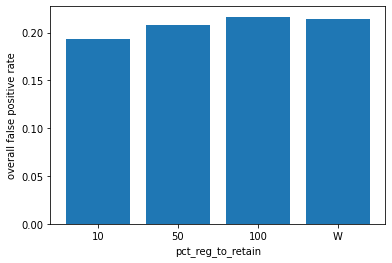

In [26]:
# threshold vs FPR ( but misleading b/c detection of all cancers might be lower with fewer regions)

print(tot_FPRs)
fig = plt.subplot()
plt.bar(x=pct_thresholds, height=tot_FPRs)
plt.ylabel("overall false positive rate")
plt.xlabel("pct_reg_to_retain")

dict_keys(['10', '50', '100', 'W'])


<AxesSubplot:xlabel='thresh', ylabel='score'>

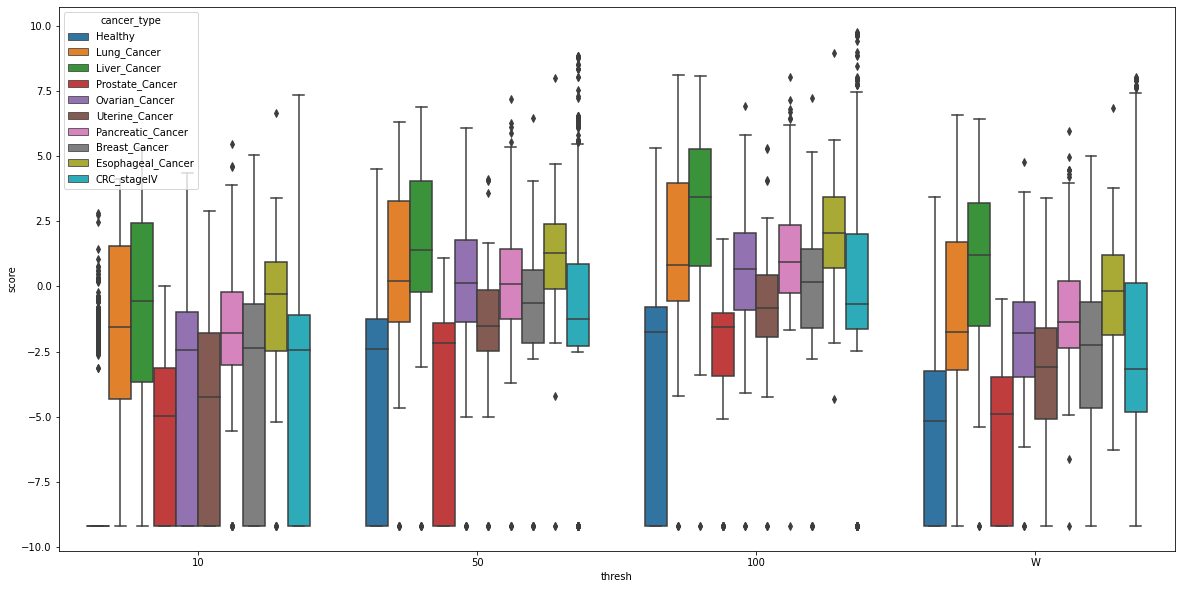

In [27]:
# cancer type, score per threshold
print(ct_scores.keys())
dfs = []
for thresh in pct_thresholds:
    data = ct_scores[thresh]
    #print(data)
    for i, cancer_type in enumerate(cancer_types):
        df = pd.DataFrame({"thresh":thresh,"cancer_type":cancer_type,"score":data[i]})
        dfs.append(df)
plot_data = pd.concat(dfs)

plt.figure(figsize=(20,10))
sns.boxplot(x="thresh",y=np.log(plot_data["score"]+0.0001),hue="cancer_type",data=plot_data)
#sns.stripplot(x="thresh",y="score",hue="cancer_type",data=plot_data)

  thresh        cancer_type       FPR
0     10            Healthy  0.100369
1     10        Lung_Cancer  0.562500
2     10       Liver_Cancer  0.692308
3     10    Prostate_Cancer  0.101695
4     10     Ovarian_Cancer  0.380000
5     10     Uterine_Cancer  0.333333
6     10  Pancreatic_Cancer  0.512500
7     10      Breast_Cancer  0.413043
8     10  Esophageal_Cancer  0.678571
9     10        CRC_stageIV  0.340659
0     50            Healthy  0.100369
1     50        Lung_Cancer  0.640625
2     50       Liver_Cancer  0.769231
3     50    Prostate_Cancer  0.118644
4     50     Ovarian_Cancer  0.600000
5     50     Uterine_Cancer  0.313725
6     50  Pancreatic_Cancer  0.612500
7     50      Breast_Cancer  0.500000
8     50  Esophageal_Cancer  0.803571
9     50        CRC_stageIV  0.364992
0    100            Healthy  0.100369
1    100        Lung_Cancer  0.625000
2    100       Liver_Cancer  0.794872
3    100    Prostate_Cancer  0.135593
4    100     Ovarian_Cancer  0.600000
5    100    

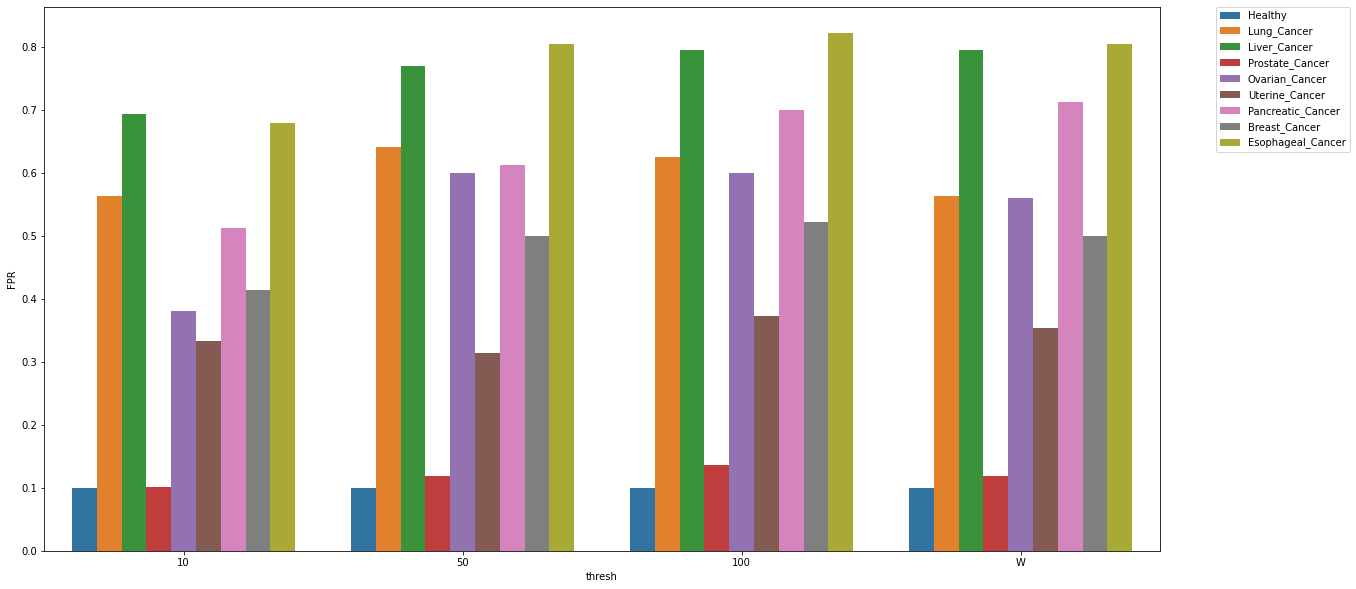

In [30]:
# cancer type, pct_FP per threshold
dfs = []
for thresh in pct_thresholds:
    data = ct_FPRs[thresh]
    df = pd.DataFrame({"thresh":np.repeat(thresh,len(data)),
                       "cancer_type":cancer_types,
                       "FPR":data})
    dfs.append(df)

plot_data = pd.concat(dfs)
#print(plot_data[plot_data["thresh"]==100.0])
print(plot_data)
plot_data = plot_data[plot_data["cancer_type"]!="CRC_stageIV"]

plt.figure(figsize=(20,10))
sns.barplot(x="thresh",y="FPR",hue="cancer_type",data=plot_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [97]:
np.log(0)

-inf